In [1]:
# Importing Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import xgboost

## Business understanding

### Focus Questions to be answered from this Analysis
After looking at data & descriptions available on Kaggle ( https://www.kaggle.com/airbnb/seattle ) about this dataset, we can focus on answering following questions through this Analysis :

1. What is the trend wrt Availability of listing on Airbnb in different Neighbourhoods of Seattle ?
2. What is the trend wrt listing-prices on Airbnb in different Neighbourhoods of Seattle ? 
3. Do we see Seasonality as well as Day-of-week influencing Prices ?
4. Can we determine important factors which influence listing-price the most on Airbnb ?

With answering above questions, we will uncover key insights around airbnb listings in Seattle area.


For anyone planning to become an airbnb host in Seattle, answers to above questions would help in understanding important insights and trends in Seattle airbnb listings!

## Data understanding

### Reading datasets
We are using "Seattle Airbnb Open Data" available on Kaggle for this Analysis

In [2]:
df_listing = pd.read_csv('../data/listings.csv') # Listing data

In [3]:
df_calendar = pd.read_csv('../data/calendar.csv') # Date wise listing info wrt price, availability

In [4]:
df_reviews = pd.read_csv('../data/reviews.csv') # listing-reviews data

In [5]:
# Quick look at few entries of listing data
df_listing.head(3)

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  

[3 rows x 92 columns]

In [6]:
# Quick look at few entries of listing-daywise pricing,availability data
df_calendar.head(3)

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN

In [7]:
# Quick look at few entries of reviews data
df_reviews.head(3)

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...

## Data understanding

In [8]:
# defining a function for plotting a trend during "data understanding" step
def plot_trend(df,color='b',title="Trendd",ylim=[0,1000]):
    '''
    INPUT:
    df : (dataframe) input dataframe which is to be used to plot graph
    color : (str) input to decide color of graph
    title : (str) input to decide graph title
    ylim : (list) input to decide value limits for Y axis
    
    Description:
    functions accepts dataframe to plot a trend graph by using index as X axis values
    '''
    df.plot(kind='bar',rot=70,alpha=0.6,color=color,ylim=ylim)
    plt.title(title)

### Q1 What is the trend wrt Availability of listing on Airbnb in different Neighborhoods of Seattle ?

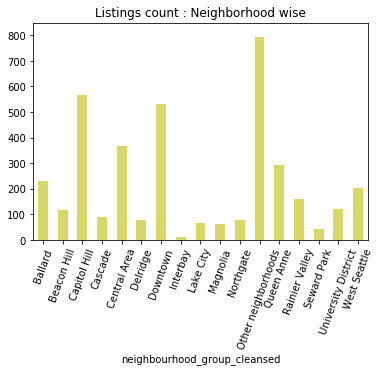

In [9]:
# Listing availability wrt "neighbourhood_group_cleansed"
df_lst_ngbrhd = df_listing.groupby(df_listing.neighbourhood_group_cleansed).count()['id']

#re-using plot_trend function to plot trends
plot_trend(df_lst_ngbrhd,color='y',title="Listings count : Neighborhood wise",ylim=[0,850]) 

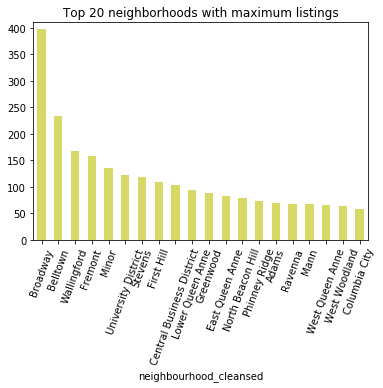

In [10]:
# Looking at top 20 neighborhoods with maximum listings 
df_lst_ngbrhd_max = df_listing.groupby(df_listing.neighbourhood_cleansed).count()\
                                .sort_values(by='id',ascending=False).head(20)['id']

#re-using plot_trend function to plot trends
plot_trend(df_lst_ngbrhd_max,color='y',title="Top 20 neighborhoods with maximum listings",ylim=[0,410]) 

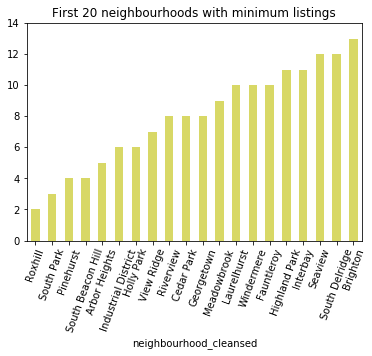

In [11]:
# Looking at First 20 neighbourhoods with minimum listings 
df_lst_ngbrhd_min = df_listing.groupby(df_listing.neighbourhood_cleansed).count()\
                                .sort_values(by='id',ascending=True).head(20)['id']

#re-using plot_trend function to plot trends
plot_trend(df_lst_ngbrhd_min,color='y',title="First 20 neighbourhoods with minimum listings",ylim=[0,14]) 

### Q2 What is the trend wrt listing-prices on Airbnb in different Neighbourhoods of Seattle ? 

In [12]:
df_listing.price.head(3)

0     $85.00
1    $150.00
2    $975.00
Name: price, dtype: object

In [13]:
df_listing['price'].dtype

dtype('O')

In [14]:
# since "Price" column is non-numeric, we need to first clean it and convert to "numeric" type
df_listing['price'] = df_listing['price'].astype(str).str.replace("[$, ]", "").astype("float")

In [15]:
# Basic stats for "price" attribute
df_listing['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Diribution of listing-prices of Seattle airbnb listings')

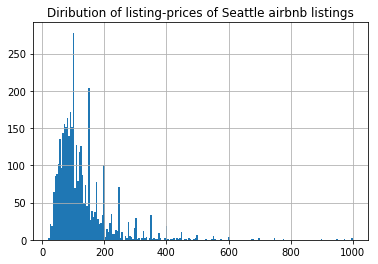

In [16]:
#Distribution of "Pricing" value
df_listing['price'].hist(bins=200)
plt.title("Diribution of listing-prices of Seattle airbnb listings")

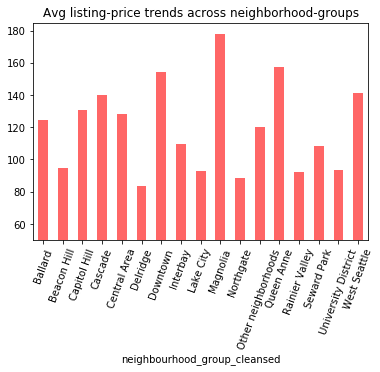

In [17]:
# Avg listing-price trends across "neighbourhood_groups"
df_price_ngbrhd = df_listing.groupby(df_listing.neighbourhood_group_cleansed).mean()['price']

#re-using plot_trend function to plot trends
plot_trend(df_price_ngbrhd,color='r',title="Avg listing-price trends across neighborhood-groups",ylim=[50,185]) 

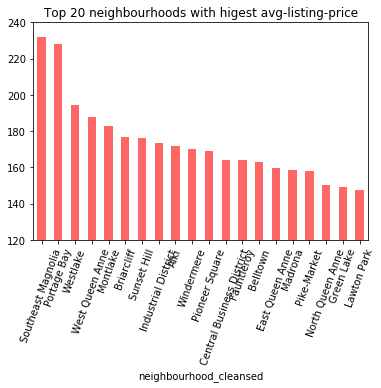

In [18]:
# Top 20 neighbourhoods with higest avg listing_price
df_price_ngbrhd_max = df_listing.groupby(df_listing.neighbourhood_cleansed).mean()\
                                .sort_values(by='price',ascending=False).head(20)['price']

#re-using plot_trend function to plot trends
plot_trend(df_price_ngbrhd_max,color='r',title="Top 20 neighbourhoods with higest avg-listing-price",ylim=[120,240]) 

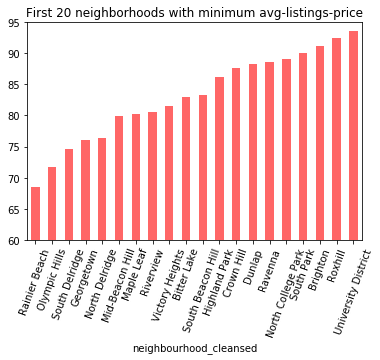

In [19]:
# First 20 neighbourhoods with minimum avg listings_price
df_price_ngbrhd_min = df_listing.groupby(df_listing.neighbourhood_cleansed).mean()\
                                .sort_values(by='price',ascending=True).head(20)['price']\

#re-using plot_trend function to plot trends
plot_trend(df_price_ngbrhd_min,color='r',title="First 20 neighborhoods with minimum avg-listings-price",ylim=[60,95]) 

### Q3 Do we see Seasonality as well as Day-of-week influencing Prices ?

In [20]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [21]:
# since Price and date are non-numeric , we need to convert it to correct data types
df_calendar['price'] = df_calendar['price'].astype(str).str.replace("[$, ]", "").astype("float")
df_calendar.loc[:,'date'] = pd.to_datetime(df_calendar['date'])

In [22]:
df_calendar.isnull().sum().sum()

459028

In [23]:
df_calendar1 = df_calendar

In [24]:
# creating additional columns for "month" and "day_name"
df_calendar1['month'], df_calendar1['day_name'] = (df_calendar1['date'].apply(lambda x: x.month),
                                                   df_calendar1['date'].apply(lambda x: x.strftime("%A")))

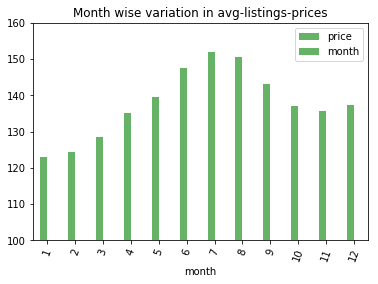

In [25]:
#Plotting month wise variation in avg_prices
df_price_month = df_calendar1.groupby(df_calendar1.month).mean().drop(['listing_id'],axis=1)

#re-using plot_trend function to plot trends
plot_trend(df_price_month,color='g',title="Month wise variation in avg-listings-prices",ylim=[100,160]) 

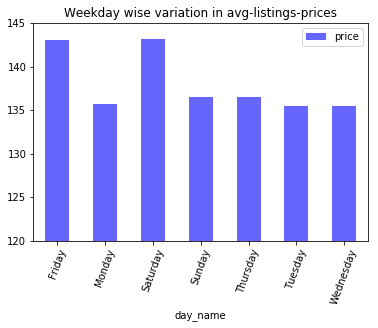

In [26]:
# plotting weekday wise variation in avg_prices
df_price_day = df_calendar1.groupby(df_calendar1.day_name).mean().drop(['listing_id','month'],axis=1)

#re-using plot_trend function to plot trends
plot_trend(df_price_day,color='b',title="Weekday wise variation in avg-listings-prices",ylim=[120,145]) 

#### Looking at seasonality trends , we clearly see a strong trend that:
Prices increase in summer season ( June-Aug ) as well as 


Prices for weekend days ( Friday, Saturday ) are also noticeably higher than prices on rest of days

### Q4 Building  model to predict prices as well as to understand key components which influence prices
We will evaluate if we can build a Regression model to predict listing_prices by using features available in df_listing dataset

## Data preparation

In [27]:
# looking at features available in df_listing
df_listing.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [28]:
# considering features availble we consider following attributes for further exploration
df_listing_shrtlst = df_listing[["host_response_rate", "host_acceptance_rate", "host_is_superhost",
               "host_listings_count", "zipcode", "property_type","room_type", "accommodates", "bathrooms", "bedrooms", 
               "beds", "price", "number_of_reviews", "review_scores_rating", "cancellation_policy", 
               "reviews_per_month"]]

##### Missing value Treament

In [29]:
#Checking for null values present in data
df_listing_shrtlst.isnull().sum()

host_response_rate      523
host_acceptance_rate    773
host_is_superhost         2
host_listings_count       2
zipcode                   7
property_type             1
room_type                 0
accommodates              0
bathrooms                16
bedrooms                  6
beds                      1
price                     0
number_of_reviews         0
review_scores_rating    647
cancellation_policy       0
reviews_per_month       627
dtype: int64

In [30]:
print("Total entries available : ",len(df_listing_shrtlst))
print("Total entries available without a single null value: ",len(df_listing_shrtlst.dropna(axis=0)))

Total entries available :  3818
Total entries available without a single null value:  2656


Deciding between "missing value dropping" vs "missing value imuting":

Even if we drop entries with missing value, we would still have ~70% if entries available from original data
Also data imputing for missing values ( either as a mean, mode or any other method ) might influence the actual trend displayed by respective feature 


One of key objectives of this analysis is also to understand key features which influence the prediction of listing price the most.
hence data imputation can possibly also influence this prediction

hence for this analysis, we choose option of "dropping missing values" over an option of "data imputation"

In [31]:
#for further analysis, we will considering entries with only non-null values
df_listing_shrtlst = df_listing_shrtlst.dropna(axis=0)

In [32]:
# For Features which ideally need to have "numeric" data types but have "non-numeric" dtype 
#         : converting them to correct dtype
df_listing_shrtlst['host_response_rate'] = df_listing_shrtlst['host_response_rate'].astype(str)
df_listing_shrtlst['host_acceptance_rate'] = df_listing_shrtlst['host_acceptance_rate'].astype(str)

df_listing_shrtlst['host_acceptance_rate'] = df_listing_shrtlst['host_acceptance_rate'].str.replace("%", "").astype("float")
df_listing_shrtlst['host_response_rate'] = df_listing_shrtlst['host_response_rate'].str.replace("%", "").astype("float")

# Since "host_is_superhost" feature has only 2 unique values, we convert it into a single feature with
# binary values and hence avoid creating un-necessary 2 columns with "one-hot-encoding" method.
df_listing_shrtlst['superhost']=np.where(df_listing_shrtlst['host_is_superhost']=='t',1,0)
del df_listing_shrtlst['host_is_superhost'] # deleting since we have created another feature "superhost"


In [33]:
# Looking at non-numeric features
df_listing_shrtlst.select_dtypes(include=['object']).columns

Index(['zipcode', 'property_type', 'room_type', 'cancellation_policy'], dtype='object')

In [34]:
# using One-Hot-Encoder, converting "non-numeric" features to "numeric" features
df_listing_shrtlst_encode = pd.get_dummies(df_listing_shrtlst)

In [35]:
df_listing_shrtlst_encode.head(2)

host_response_rate  host_acceptance_rate  host_listings_count  \
0                96.0                 100.0                  3.0   
1                98.0                 100.0                  6.0   

   accommodates  bathrooms  bedrooms  beds  price  number_of_reviews  \
0             4        1.0       1.0   1.0   85.0                207   
1             4        1.0       1.0   1.0  150.0                 43   

   review_scores_rating  ...  property_type_Tent  property_type_Townhouse  \
0                  95.0  ...                   0                        0   
1                  96.0  ...                   0                        0   

   property_type_Treehouse  property_type_Yurt  room_type_Entire home/apt  \
0                        0                   0                          1   
1                        0                   0                          1   

   room_type_Private room  room_type_Shared room  \
0                       0                      0   
1                       0                      0   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             1   
1                             0                             0   

   cancellation_policy_strict  
0                           0  
1                           1  

[2 rows x 62 columns]

In [36]:
#prepare train and test datasets for modelling

X = df_listing_shrtlst_encode.drop(columns = 'price')
y = df_listing_shrtlst_encode['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Data modeling

#### In this step we will be building following 2 ML models
1. Random Forest
2. XGBoost

In [37]:
#training and evaluating Random Forest regressor model
mod_rf = RandomForestRegressor(n_estimators=100, 
                               criterion='mse',
                               n_jobs=-1)
mod_rf.fit(X_train, y_train)

#calculate scores for the model
y_train_preds = mod_rf.predict(X_train)
y_test_preds = mod_rf.predict(X_test)

print('train MSE: %.1f, test MSE: %.1f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))

print('train R^2 : %.2f, test R^2 : %.2f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

train MSE: 388.1, test MSE: 2342.2
train R^2 : 0.94, test R^2 : 0.65


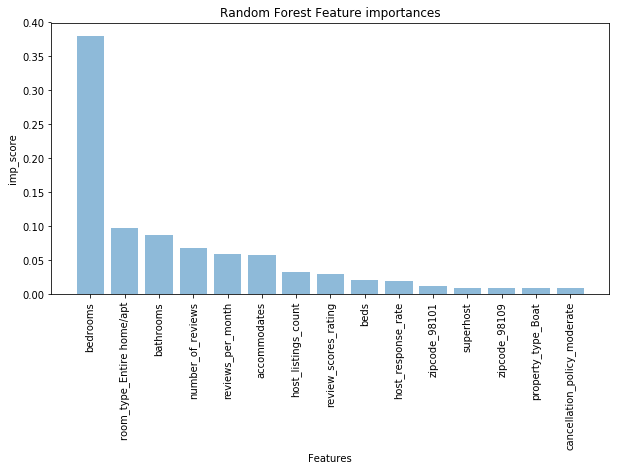

In [38]:
#get feature importances from RF model
headers = ["feature", "imp_score"]
values = sorted(zip(X_train.columns, mod_rf.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['imp_score'], ascending = False)

features = forest_feature_importances['feature'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['imp_score'][:15]

#plotting feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('imp_score')
plt.xlabel('Features')
plt.title('Random Forest Feature importances')

plt.show()

In [39]:
#training and evaluating XGboost regressor model
mod_xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
mod_xgb.fit(X_train,y_train)

y_train_preds = mod_xgb.predict(X_train)
y_test_preds = mod_xgb.predict(X_test)

print('train MSE : %.1f, test MSE: %.1f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('train R^2: %.2f, test R^2: %.2f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


train MSE : 380.1, test MSE: 2234.6
train R^2: 0.94, test R^2: 0.66


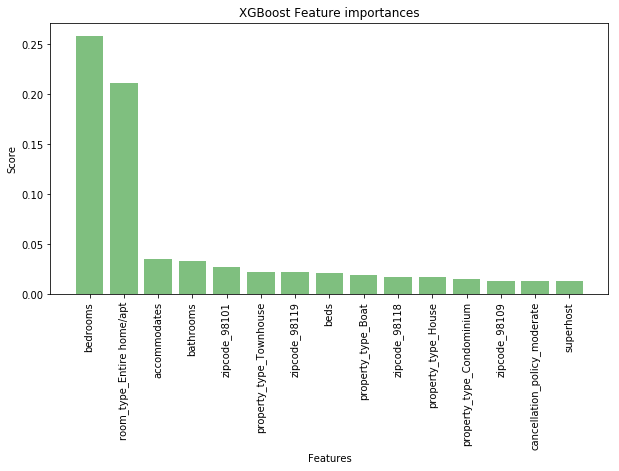

In [40]:
#get feature importances from the model
headers = ["feature", "imp_score"]
values = sorted(zip(X_train.columns, mod_xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 15 features
features = xgb_feature_importances['feature'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['imp_score'][:15]
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5,color='g')
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('XGBoost Feature importances')
 
plt.show()

## Results evaluation

Test R^2 of 0.64 ( RF ) and 0.66 (XGboost) with just initial iteration seems encouraging .

and as a future scope, we can aim for a definite improvement in model performance 

#### With RF model, following 4 come out to be most imp features in predicting listing-prices
1. bedrooms
2. room_type
3. bathrooms
4. number_of_reviews

#### With XGBoost model, following 4 come out to be most imp features in predicting listing-prices
1. bedrooms
2. room_type
3. accomodates
4. bathrooms

We also see quite a few features common between RF and XGboost in top10 

#### Looking at results of Random Forest as well as XGBoost regression models, we can conclude that:
1. There is a scope to build model to predict listing_prices with acceptable accuracy and
2. There only few features which are more critical in influecing listing-prices than rest of features